In [1]:
# import libraries
import numpy as np


# Section 1

## Question 6
Below we will use the numpy library to calculate the eigenvalues and eigenvectors for the 
graph laplacian we calculated earlier numerically

In [2]:
# calculate the eigenvalues and eigenvectors
L = np.array([
    [2, -1, -1, 0, 0],
    [-1, 2, -1, 0, 0],
    [-1, -1, 2, 0, 0],
    [0, 0, 0, 1, -1],
    [0, 0, 0, -1, 1]
])

eigenvalues, eigenvectors = np.linalg.eig(L)

idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]


In [3]:
# print results
print("Eigenvalues:", eigenvalues)


Eigenvalues: [-4.4408921e-16  0.0000000e+00  2.0000000e+00  3.0000000e+00
  3.0000000e+00]


In [4]:
print("Eigenvectors:\n", eigenvectors)

Eigenvectors:
 [[-0.57735027  0.          0.          0.81649658  0.29329423]
 [-0.57735027  0.          0.         -0.40824829 -0.80655913]
 [-0.57735027  0.          0.         -0.40824829  0.5132649 ]
 [ 0.          0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.70710678 -0.70710678  0.          0.        ]]


The first two eigenvalues are ~ 0 and correspond to the connected components. The corresponding first two eigenvectors highlight that the first three nodes 1 to 3 belong to a single component and the nodes 4 and 5 belong to another component. 

# Section 3


In [10]:
# import libraries
import cv2
import matplotlib.pyplot as plt
import time

In [25]:
# we will use assistance to convert images to the necessary format
def pixel_image(path):
    # cv2 uses BGR format for pizel color representation, not RGB
    image_pixels = cv2.imread(path)
    
    # we will use matplotlib to visualize later so lets get our data from BGR to RGB format
    image_rgb = cv2.cvtColor(image_pixels, cv2.COLOR_BGR2RGB) 
    # print(image_pixels.shape)
    pixels = image_rgb.reshape(-1, 3)
    
    return pixels, image_rgb

In [40]:
# create the pixel input representation for the three images
football = pixel_image('./data/football.bmp')[0]
coastal = pixel_image('./data/coastal-abstract.jpeg')[0]
greycat = pixel_image('./data/256px-Greycat.jpg')[0]

In [51]:
# test
mini_matrix = football[0:3]
print(mini_matrix)

centroids= [[75,82,85], [73, 81, 80]]

print(centroids)

print(mini_matrix[:, np.newaxis] - centroids)

print((mini_matrix[:, np.newaxis] - centroids)**2)

print(((mini_matrix[:, np.newaxis] - centroids)**2).sum(axis=2))

print(np.argmin(((mini_matrix[:, np.newaxis] - centroids)**2).sum(axis=2), axis=1))


[[76 84 87]
 [73 81 84]
 [68 76 79]]
[[75, 82, 85], [73, 81, 80]]
[[[ 1  2  2]
  [ 3  3  7]]

 [[-2 -1 -1]
  [ 0  0  4]]

 [[-7 -6 -6]
  [-5 -5 -1]]]
[[[ 1  4  4]
  [ 9  9 49]]

 [[ 4  1  1]
  [ 0  0 16]]

 [[49 36 36]
  [25 25  1]]]
[[  9  67]
 [  6  16]
 [121  51]]
[0 0 1]


In [41]:
# set up your number of clusters k
k_list = [2,4,8,16,32]

In [62]:
'''
Create the k-means function
Input: matrix of pixels, value for k
Output: a matrix with an assigned cluster for each pixel, a matrix of k centroids with BGR values for each,
a matrix of initialzed centroid values based on random initialization, the number of iterations to converge, total time to converge for each
'''
def k_means(matrix, k):
    
    # start the timer
    num_iterations = 0
    start_time = time.time()
    
    # randomly initialize k centroids: choosing full random instead of selecting from an existing centroid
    init_centroids = np.random.randint(0, 256, size = (k,3))
    
    # we're going to update our centroids but we also want to maintain our initial centroids to compare
    centroids = init_centroids.copy()
    
    # initialize the vector which will hold the cluster assignment for each pixel
    cluster_assignments = np.zeros(matrix.shape[0], dtype = int)
    # print(cluster_assignments)
    
    # we will continue the below until our condition of convergence is met
    
    while True:
        # assign each pixel to nearest centroid
        # for i in range(matrix.shape[0]):
        #     # use l2 norm squared or euclidian squared distance to assign
        #     distances = np.sum((matrix[i] - centroids)**2, axis = 1)
        #     cluster_assignments[i] = np.argmin(distances)
        
        # assign each pixel to nearest centroid: vectorized approach using numpy to speed things up
        distances = ((matrix[:, np.newaxis] - centroids)**2).sum(axis=2)
        cluster_assignments = np.argmin(distances, axis=1)
        
        # now that assignment is complete, update the centroids using mean -> type int of pixel in that cluster
        updated_centroids = centroids.copy()
        for j in range(k):
            points_in_cluster = matrix[cluster_assignments == j]

            # per assignment, make sure to handle empty clusters through a random reassignment or deletion (let's reassign)
            if len(points_in_cluster) > 0:
                updated_centroids[j] = np.mean(points_in_cluster, axis = 0).astype(int)
            else:
                updated_centroids[j] = np.random.randint(0, 256, size=(3,))
                
        
        # check to see if current pixel assignments are the same as previous run, if so, end the loop
        if np.array_equal(updated_centroids, centroids):
            break
        
        # update necessary vars
        centroids = updated_centroids.copy()
        num_iterations += 1
    
    # end the timer
    end_time = time.time()
    
    time_elapsed = end_time - start_time
    
    # print(num_iterations, time_elapsed)
    
    return cluster_assignments, centroids, init_centroids, num_iterations, time_elapsed

In [37]:
# test the k-means function

In [67]:
'''
 Write a function that takes in your outputs from the k-means function and returns original visual and 
 newly created visuals after running for given k 5 times (chosen arbitraily)
 Input: image
 Output: original image, print new images, print initialization centroids for each, number iterations to converge for each, and total time in seconds for each to converge
'''

def run_k_means_and_visualize(path, k_list):
    
    # get the matrix for the image passed in
    image_pixels, image_shape = pixel_image(path)
    
    # let's first display the original image to compare our renditions against
    plt.figure()
    plt.imshow(image_shape)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    # run this for each value of k
    for k in k_list:
        
        # initialize the values we are going to print for the best iteration
        best_wcss = float('inf')
        best_iteration = None
        best_compressed_image = None
        best_init_centroids = None
        best_num_iterations = None
        best_time_elapsed = None
        
        # run this 5 times with diff rand initializations
        for iteration in range(5):
            
            # get the vals from our k_means function run
            cluster_assignments, centroids, init_centroids, num_iterations, time_elapsed = k_means(image_pixels, k)
            
            # calculate the within-cluster sum of squares as our optimization metric
            # for each cluster, take the sum of the squared differences between each data point and the centroid
            # then sum up the total for te iteration
            wcss = sum(np.sum((image_pixels[cluster_assignments == j] - centroids[j]) ** 2) for j in range(k))
            
            # make sure to update best wcss and other best_vars 
            if wcss < best_wcss:
                best_wcss = wcss
                best_iteration = iteration + 1
                best_compressed_pixels = centroids[cluster_assignments]
                best_compressed_image = best_compressed_pixels.reshape(image_shape.shape)
                best_init_centroids = init_centroids
                best_num_iterations = num_iterations
                best_time_elapsed = time_elapsed
            
            
        # print the information desired for best iteration
        print(f"k = {k}, Best Iteration {best_iteration}:")
        print(f"Best Initialized Centroids:\n{best_init_centroids}")
        print(f"Number of Centroid Updates for Best Iteration: {best_num_iterations}")
        print(f"Total Time (seconds) for Best Iteration: {best_time_elapsed:.2f}\n")
        
        # display the image
        plt.figure()
        plt.imshow(best_compressed_image)
        plt.title(f'k = {k}, Iteration {best_iteration}')
        plt.axis('off')
        plt.show()

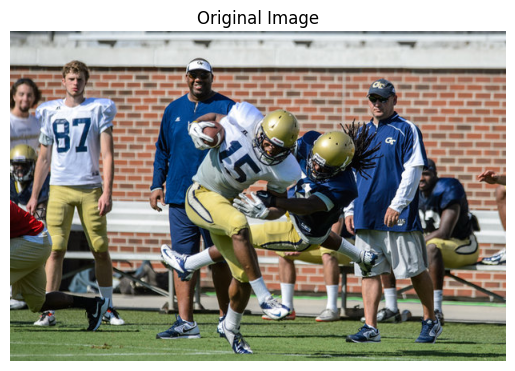

k = 2, Best Iteration 1:
Best Initialized Centroids:
[[133   5  89]
 [255 239  62]]
Number of Centroid Updates for Best Iteration: 9
Total Time (seconds) for Best Iteration: 0.29



k = 4, Best Iteration 3:
Best Initialized Centroids:
[[194 173 218]
 [ 87 165 123]
 [ 25 229  44]
 [116 152 188]]
Number of Centroid Updates for Best Iteration: 13
Total Time (seconds) for Best Iteration: 0.70



k = 8, Best Iteration 2:
Best Initialized Centroids:
[[209 219  46]
 [135 144 153]
 [160 116 243]
 [151 213  40]
 [116 231  13]
 [164   6 153]
 [213 215 191]
 [231 139  25]]
Number of Centroid Updates for Best Iteration: 28
Total Time (seconds) for Best Iteration: 2.49



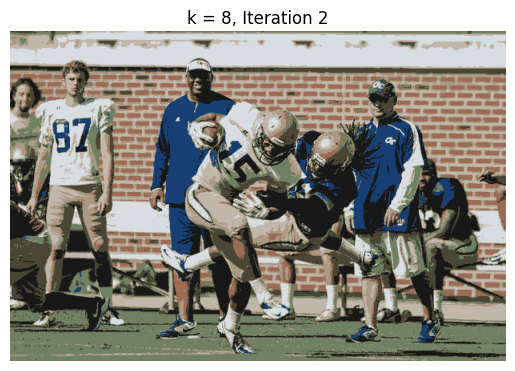

k = 16, Best Iteration 4:
Best Initialized Centroids:
[[ 96 167 186]
 [199 131 248]
 [151  83 221]
 [203 159 109]
 [ 29  87  25]
 [209 248  93]
 [118 106  28]
 [126  10  94]
 [233 243   6]
 [205 188 132]
 [  4  33 111]
 [ 76 163  39]
 [ 26 201 242]
 [ 32 206  81]
 [107 118 215]
 [154 237  23]]
Number of Centroid Updates for Best Iteration: 35
Total Time (seconds) for Best Iteration: 5.60



k = 32, Best Iteration 1:
Best Initialized Centroids:
[[191  95 167]
 [246  69 156]
 [ 21 147 247]
 [194 202  84]
 [189 213 123]
 [126 113  81]
 [ 16   9  40]
 [214  25  36]
 [ 87  16 168]
 [ 88 202 253]
 [112  19 101]
 [ 90 235  98]
 [ 84 134  73]
 [241 155  57]
 [125 167  43]
 [121  36 136]
 [225  71 195]
 [156   8 249]
 [ 44 137 130]
 [227   3  20]
 [242 118  97]
 [ 34 159  91]
 [ 90 108 179]
 [185 224  99]
 [ 94  35 226]
 [ 98  83   0]
 [245 226 184]
 [164 228   7]
 [ 56 137 209]
 [250 179 229]
 [105  93 202]
 [166  80 141]]
Number of Centroid Updates for Best Iteration: 60
Total Time (seconds) for Best Iteration: 18.69



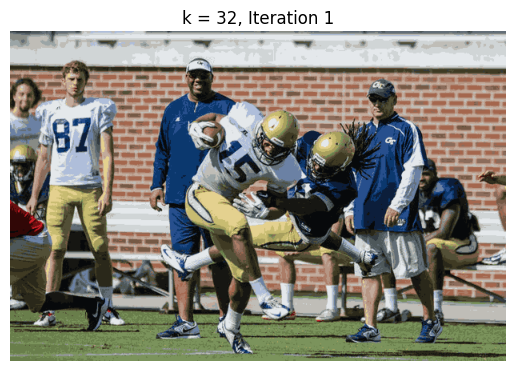

In [68]:
# football
run_k_means_and_visualize('./data/football.bmp', k_list)

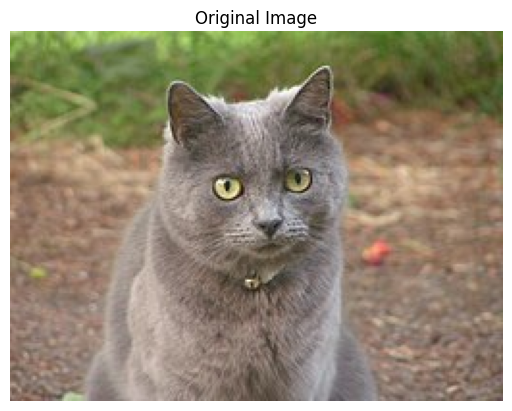

k = 2, Best Iteration 2:
Best Initialized Centroids:
[[147 204 237]
 [ 73  12 183]]
Number of Centroid Updates for Best Iteration: 6
Total Time (seconds) for Best Iteration: 0.04



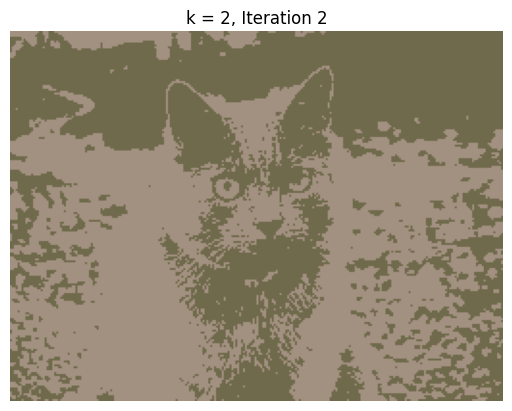

k = 4, Best Iteration 5:
Best Initialized Centroids:
[[ 91  15 177]
 [ 28 228 223]
 [245 150 202]
 [ 38 109  99]]
Number of Centroid Updates for Best Iteration: 17
Total Time (seconds) for Best Iteration: 0.16



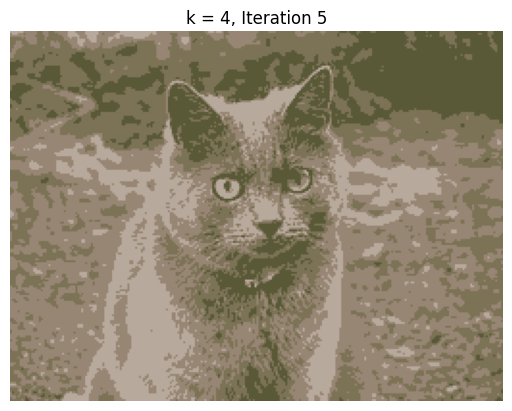

k = 8, Best Iteration 1:
Best Initialized Centroids:
[[ 82  14 225]
 [110 127  38]
 [ 82  30 117]
 [ 14 119 109]
 [227 200 169]
 [ 26 125  89]
 [220 228 219]
 [175 159 108]]
Number of Centroid Updates for Best Iteration: 40
Total Time (seconds) for Best Iteration: 0.67



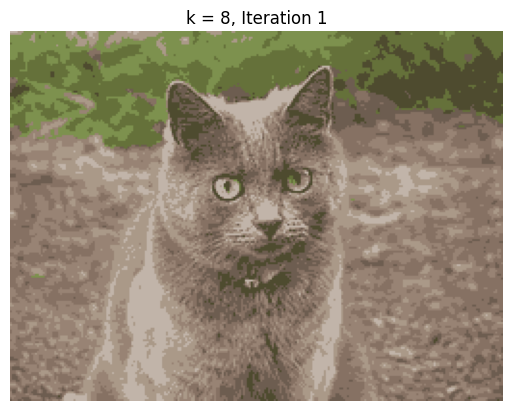

k = 16, Best Iteration 5:
Best Initialized Centroids:
[[176  33 170]
 [ 39  61  23]
 [121 227 143]
 [138 191 141]
 [ 96  73 253]
 [ 83 157  21]
 [ 43 149  52]
 [ 54 204 130]
 [192  46  16]
 [121  78 140]
 [ 92  53  50]
 [ 10 240  70]
 [165  31   3]
 [ 46 172  33]
 [ 34 171 223]
 [  0  84  64]]
Number of Centroid Updates for Best Iteration: 49
Total Time (seconds) for Best Iteration: 1.54



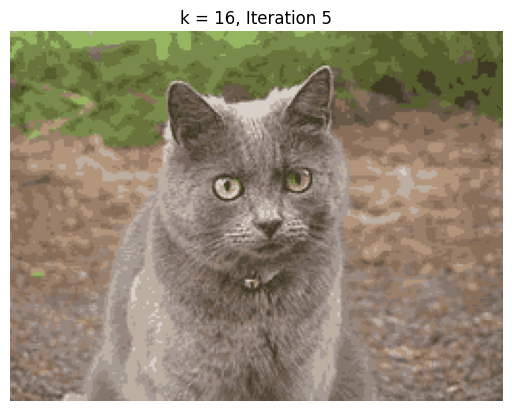

k = 32, Best Iteration 1:
Best Initialized Centroids:
[[182 186  69]
 [146 150  52]
 [116 174 140]
 [203 202 203]
 [140  67 237]
 [121 219 162]
 [ 31 165 153]
 [ 11  44 252]
 [236 122 106]
 [ 23  17 146]
 [ 30 231 149]
 [213  63 254]
 [252 140 243]
 [125 240 104]
 [213  10 202]
 [ 21 161  89]
 [191 197  79]
 [ 88 114  27]
 [211 178  86]
 [144 247 154]
 [ 39  61  10]
 [248  11 228]
 [149 158 228]
 [ 85  87 115]
 [ 92  30 164]
 [197  92 255]
 [214 193   2]
 [206 147 162]
 [235  14  63]
 [197  15 126]
 [124  74  37]
 [ 89  18  17]]
Number of Centroid Updates for Best Iteration: 64
Total Time (seconds) for Best Iteration: 3.80



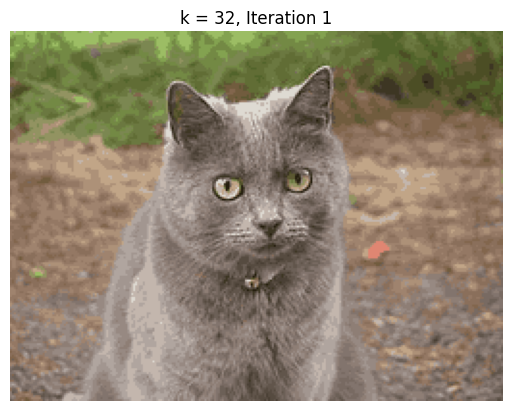

In [69]:
# cat (self chosen image)
run_k_means_and_visualize('./data/256px-Greycat.jpg', k_list)

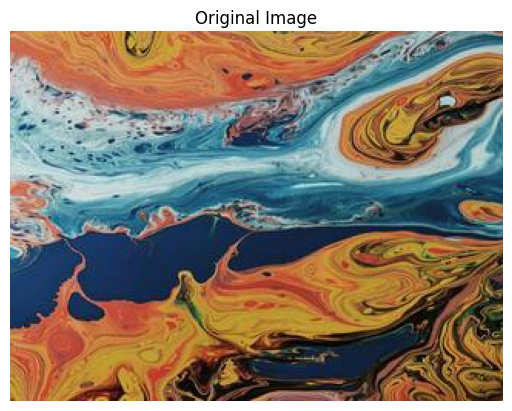

k = 2, Best Iteration 1:
Best Initialized Centroids:
[[108 193 135]
 [  3 193 146]]
Number of Centroid Updates for Best Iteration: 8
Total Time (seconds) for Best Iteration: 0.08



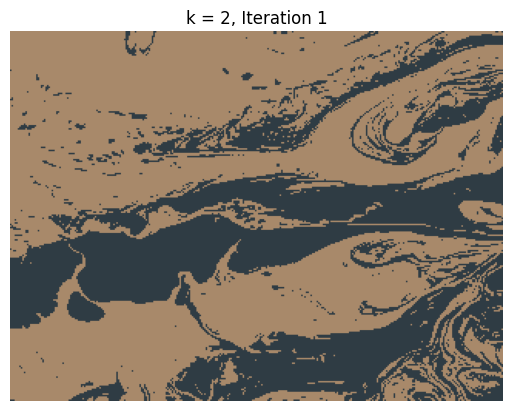

k = 4, Best Iteration 1:
Best Initialized Centroids:
[[116  20 114]
 [212 177 168]
 [ 13 231 207]
 [245 201 232]]
Number of Centroid Updates for Best Iteration: 9
Total Time (seconds) for Best Iteration: 0.15



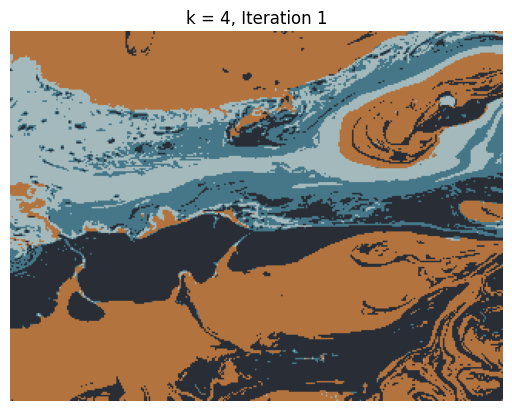

k = 8, Best Iteration 4:
Best Initialized Centroids:
[[ 30  12 148]
 [141  81  65]
 [211 146  42]
 [229 150 195]
 [115 140 250]
 [220   0 161]
 [ 51  86  67]
 [ 10  61 222]]
Number of Centroid Updates for Best Iteration: 18
Total Time (seconds) for Best Iteration: 0.47



k = 16, Best Iteration 3:
Best Initialized Centroids:
[[203 214  80]
 [213 150 232]
 [146  25  50]
 [215  79 171]
 [140 220 197]
 [181 241  69]
 [ 67  30 140]
 [206 114 231]
 [ 65 192 121]
 [ 88 235 218]
 [ 56 155  59]
 [146 104 178]
 [ 14  81  49]
 [156 196 123]
 [ 98 219 100]
 [139  63  58]]
Number of Centroid Updates for Best Iteration: 43
Total Time (seconds) for Best Iteration: 2.16



k = 32, Best Iteration 5:
Best Initialized Centroids:
[[134  74   0]
 [ 17 160 211]
 [ 55 230  73]
 [ 14 149 148]
 [137  17  52]
 [176 135 242]
 [155  84 221]
 [189 211  48]
 [157 152  22]
 [ 76 162 204]
 [ 17  59 102]
 [ 46 176 130]
 [  7  80  50]
 [ 23 166 228]
 [  0  61 220]
 [174 205 228]
 [137 234   2]
 [163  61 192]
 [ 98 190 233]
 [111 158  18]
 [107 133 224]
 [172  71 160]
 [216  90  39]
 [151 183 237]
 [164 153  50]
 [233 179  80]
 [158 151  74]
 [214  52 160]
 [215  94  45]
 [ 16   8 130]
 [ 30 126   4]
 [ 90  98 145]]
Number of Centroid Updates for Best Iteration: 85
Total Time (seconds) for Best Iteration: 7.92



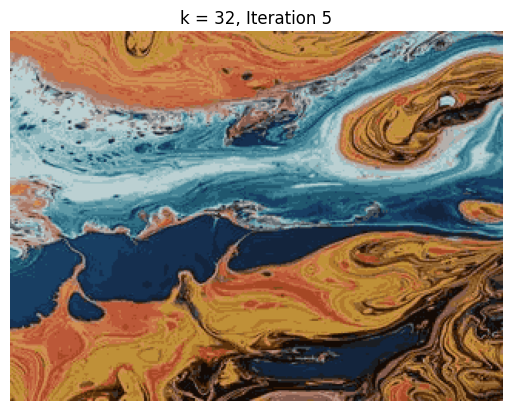

In [70]:
# coastal abstract
run_k_means_and_visualize('./data/coastal-abstract.jpeg', k_list)